# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Model](#5.4_Load_Model)
  * [5.5 Load Data](#5.5_Load_Data)
  * [5.6 Refit Model On All Available Data (excluding Big Mountain)](#5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain))
  * [5.7 Calculate Expected Big Mountain Ticket Price From The Model](#5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model)
  * [5.10 Summary](#5.10_Summary)
  * [5.11 Further work](#5.11_Further_work)


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we will check our model on some evaluation data from 2022. This sets of data includes climate and weather information 
at Kathmandu during January of 2022. In addition to that, we will take total data and make prediction using Long Short-Term Memory Model, 
also known as LSTM. For time series analysis like this project, it is important to carry information from earlier time steps to later ones. The LSTM model has internal mechanism called gates which regulates the flow of information. The gates can learn which which data in 
a sequence to keep or thrown away. By doing that, it can pass relevant information down the long chain of sequences to make predictions. 


<img src="../images/lstm.png" alt="drawing" style="width:500px;"/>


## 5.3 Imports<a id='5.3_Imports'></a>

In [30]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import layers
import tensorflow as tf

## 5.5 Load Data<a id='5.5_Load_Data'></a>

In [2]:
df = pd.read_csv('../data/realdata/exploratory_air_quality.csv',index_col='date')

In [3]:
df = df.reindex(columns=['AQI','T','H','PP','VV','V','VM','season'])

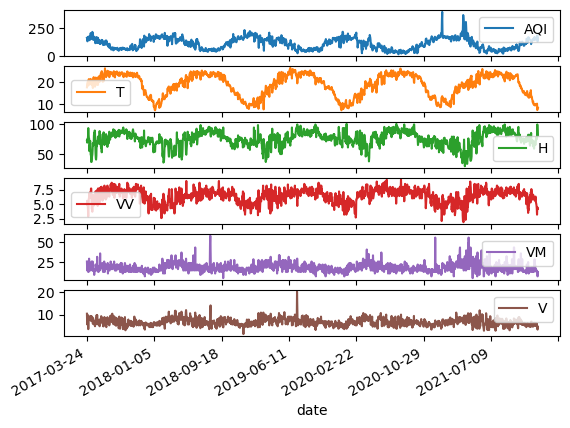

In [27]:
df[['AQI','T', 'H','VV', 'VM', 'V']].plot(subplots=True)
plt.show();

In [5]:
df = pd.get_dummies(df, columns=['season'], prefix='season')

In [6]:
scaler = MinMaxScaler()

In [7]:
scaler.fit(df)
scaled_train = scaler.transform(df)

In [8]:
features = scaled_train
target = scaled_train[:,0]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle = False)

In [10]:
# define generator
win_length = 10
batch_size = 10
num_features=11
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.Dense(1))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           71680     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10, 128)           0         
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False)

Epoch 1/50
133/133 [==============================] - 9s 30ms/step - loss: 0.0226 - mean_absolute_error: 0.1206 - val_loss: 0.0267 - val_mean_absolute_error: 0.1056
Epoch 2/50
133/133 [==============================] - 3s 22ms/step - loss: 0.0122 - mean_absolute_error: 0.0866 - val_loss: 0.0251 - val_mean_absolute_error: 0.1192
Epoch 3/50
133/133 [==============================] - 3s 23ms/step - loss: 0.0098 - mean_absolute_error: 0.0767 - val_loss: 0.0119 - val_mean_absolute_error: 0.0673
Epoch 4/50
133/133 [==============================] - 3s 22ms/step - loss: 0.0098 - mean_absolute_error: 0.0787 - val_loss: 0.0124 - val_mean_absolute_error: 0.0724
Epoch 5/50
133/133 [==============================] - 3s 23ms/step - loss: 0.0083 - mean_absolute_error: 0.0716 - val_loss: 0.0117 - val_mean_absolute_error: 0.0637
Epoch 6/50
133/133 [==============================] - 4s 27ms/step - loss: 0.0095 - mean_absolute_error: 0.0769 - val_loss: 0.0111 - val_mean_absolute_error: 0.0695
Epoch 7/50

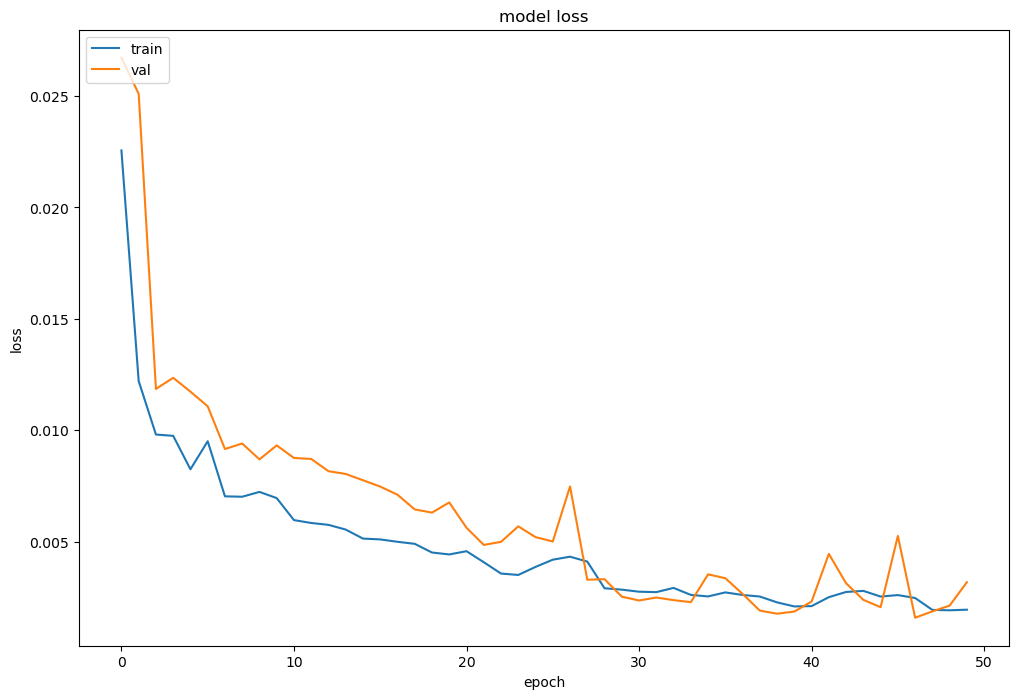

In [28]:
# plot history
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [14]:
model.evaluate(test_generator, verbose=0) 

[0.0031853620894253254, 0.04367566481232643]

In [15]:
predictions=model.predict(test_generator)

In [16]:
predictions.shape

(325, 1)

In [17]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)

In [18]:
rev_trans=scaler.inverse_transform(df_pred)

In [19]:
df_final=df[predictions.shape[0]*-1:]

In [20]:
df_final.count()

AQI         325
T           325
H           325
PP          325
VV          325
V           325
VM          325
season_1    325
season_2    325
season_3    325
season_4    325
dtype: int64

In [21]:
df_final['AQI_Pred']=rev_trans[:,0]

<ipython-input-21-59dcadcadc3d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['AQI_Pred']=rev_trans[:,0]


In [22]:
rev_trans[:,0]

array([161.25154972, 145.82119161, 131.63555676, 155.31361729,
       162.48180711, 189.7405448 , 165.66284478, 175.91109505,
       178.66528741, 160.97292846, 148.8114365 , 153.34941578,
       162.56124449, 139.4307977 , 180.04550612, 170.78834951,
       180.65993083, 189.52177408, 180.33493704, 173.84432667,
       158.13995731, 152.63404793, 144.94186211, 151.73693699,
       158.39818555, 166.29468757, 148.57601982, 169.50622392,
       165.80878654, 136.41761634, 146.42774752, 152.8543061 ,
       154.72228801, 145.31209296, 147.13006884, 154.52987152,
       166.37112731, 169.75241619, 188.35329753, 192.74217844,
       170.39168495, 170.68306887, 198.53100115, 203.60704488,
       185.61427504, 176.00373793, 210.66318667, 262.38793188,
       303.1216374 , 268.01015866, 213.7704643 , 186.11174649,
       149.57815024, 159.63372287, 197.93008852, 215.05304408,
       247.71277386, 270.83479548, 245.86577541, 155.29733467,
       144.89085686, 143.01824224, 175.36105141, 212.42

In [23]:
df_final.head()

,AQI,T,H,PP,VV,V,VM,season_1,season_2,season_3,season_4,AQI_Pred
date,,,,,,,,,,,,
2021-02-06,171.0,8.6,75.0,1.27,6.1,7.6,24.1,1,0,0,0,161.251550
2021-02-07,134.0,9.4,62.0,0.00,6.8,6.3,28.7,1,0,0,0,145.821192
2021-02-08,129.0,11.9,54.0,0.00,6.1,5.7,13.0,1,0,0,0,131.635557
2021-02-09,171.0,12.1,65.0,0.00,6.3,5.7,14.8,1,0,0,0,155.313617
2021-02-10,170.0,12.7,70.0,0.00,4.0,7.0,16.5,1,0,0,0,162.481807


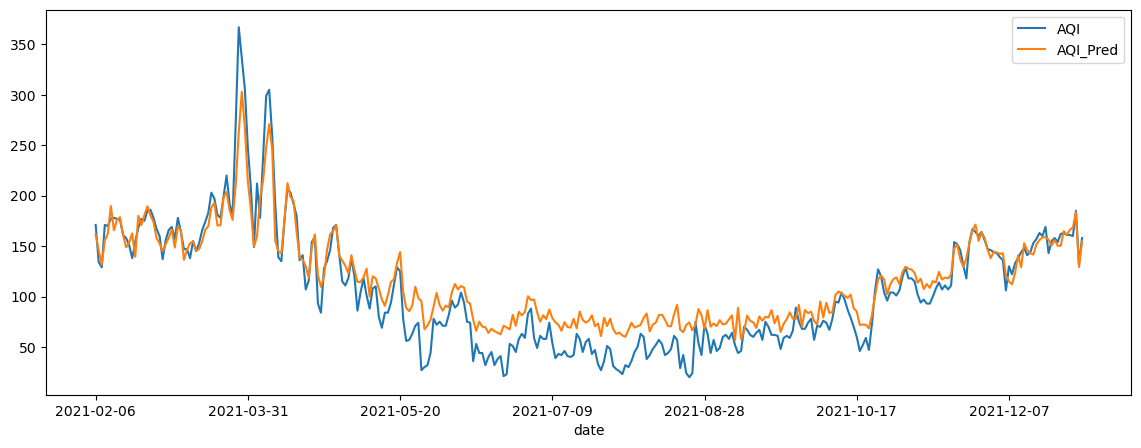

In [29]:
df_final[['AQI','AQI_Pred']].plot(figsize=(14,5))
plt.show();

In [31]:
rmse= np.sqrt(mean_squared_error(df_final['AQI'],df_final['AQI_Pred']))
print(rmse)

21.5032649112448
